In [1]:
# from community import community_louvain
import gc
import logging
import os
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import random
from scipy.optimize import differential_evolution, basinhopping, linprog
import tensorflow as tf
import tensorflow_constrained_optimization as tfco
# from tensorflow import keras
# from tensorflow.keras import layers
import tensorflow_probability as tfp
import warnings
logger = tf.get_logger()

os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [265]:
logging.basicConfig(encoding='utf-8', level=logging.INFO,
                    force = True)

In [3]:
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
class DnnResult():
    def __init__(self, theta, stuck):
        self.theta = theta
        self.stuck = stuck

In [5]:
class ValidationResult():
    def __init__(self, valid, can_add_nodes, contains_extra_nodes):
        self.valid = valid
        self.can_add_nodes = can_add_nodes
        self.contains_extra_nodes = contains_extra_nodes        

In [6]:
def graph1_adjacency_matrix():
    return np.array([
        [0, 1, 1, 0, 0, 0, 1, 0, ],
        [1, 0, 0, 1, 0, 0, 0, 1, ],
        [1, 0, 0, 1, 1, 0, 0, 0, ],
        [0, 1, 1, 0, 0, 1, 0, 0, ],
        [0, 0, 1, 0, 0, 1, 1, 0, ],
        [0, 0, 0, 1, 1, 0, 0, 1, ],
        [1, 0, 0, 0, 1, 0, 0, 1, ],
        [0, 1, 0, 0, 0, 1, 1, 0, ],
    ])


In [7]:
def build_test_graph1():
    adj_mat = graph1_adjacency_matrix()
    N = len(adj_mat)

    G = nx.Graph()
    for i in range(N):
        G.add_node(i)

    for i in range(N):
        for j in range(N):
            if adj_mat[i][j] == 1:
                G.add_edge(i, j)
                G.add_edge(j, i)
    return G

In [66]:
def clip(l,r,x):
    return max(l,min(r,x))

def calc_W(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    W = np.zeros((n,n+m+m_c),dtype= 'float32')
    for i in range(n):
        W[i][i] = 1
    j = n
    for edge in G.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    for edge in C.edges():
        x = int(edge[0])
        y = int(edge[1])
        W[x][j] = 1
        W[y][j] = 1
        j+=1
    return W

def calc_b(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    b = np.array([-1/2 for i in range(n)])
    b_m = np.array([-1 for i in range(m+m_c)])
    return np.concatenate((b,b_m))

def calc_w(G, C):
    n = len(G.nodes())
    m = len(G.edges())
    m_c = len(C.edges())
    w = np.array([-1 for i in range(n)])
    w_n = np.array([n for i in range(m)])
    w_c = np.array([-1 for i in range(m_c)])
    return np.concatenate((w,w_n,w_c))

def build_theta(G):
    n = len(G.nodes())
    max_degree = max([G.degree(i) for i in range(n)])
#     logging.debug("Max degree = {}".format(max_degree))
    if max_degree == 0:
        return np.array([1 for i in range(n)])
    return np.array([clip(0,1,1 - G.degree(i)/max_degree + random.random()/10) for i in range(n)])
#     return np.array([random.random() for i in range(n)])

def build_network(G):
    logging.debug("Build network on graph G:{}.".format(str(G)))
    C = nx.complement(G)
    W = calc_W(G, C)
    b = calc_b(G, C)
    w = calc_w(G, C)
    theta = build_theta(G)
#     logging.debug("Initial theta = {}".format(theta))
    return (W,b,w, theta, C)


In [178]:
def get_result_nodes(theta, alpha = 0.5):
    return set(np.argwhere(theta > alpha).reshape(-1))

def not_connected_nodes_exist_in_G(G, result_nodes):
    for v in G.nodes():
        if v not in result_nodes:
            node_not_connected_to_G = True
            for edge in G.neighbors(v):
                if edge in result_nodes:
                    node_not_connected_to_G = False
                    break
            if node_not_connected_to_G:
                return True
    return False
            
def graph_has_no_edges(G, result_nodes):
    for v in result_nodes:
        for edge in G.neighbors(v):
            if edge in result_nodes:
                return False
    return True

def mis_is_valid(G, mis):
    has_extra_nodes = not graph_has_no_edges(G, mis)
    not_connected_nodes_exist = not_connected_nodes_exist_in_G(G, mis)
    return ValidationResult(not has_extra_nodes and not not_connected_nodes_exist,
                            not_connected_nodes_exist, has_extra_nodes)
               
def result_is_valid(G, theta):
    result_nodes = get_result_nodes(theta)
    return mis_is_valid(G, result_nodes).valid

def network(theta,e_n,W_t,b,w_t):
    h = tf.math.multiply(e_n,theta)
    h = tf.linalg.matvec(W_t,h)
    h = tf.add(h,b)
    h = tf.nn.relu(h)
    h = tf.tensordot(w_t,h, 1)
    return h
    
def network_evol(theta,e_n,W_t,b,w_t):
    return network(theta,e_n,W_t,b,w_t).numpy()

def loss(theta,e_n,W_t,b,w_t,h_d):
#     with tf.GradientTape() as tape:
    h1 = tf.math.multiply(e_n,theta)
    h2 = tf.linalg.matvec(W_t,h1)
    h3 = tf.add(h2,b)
    h4 = tf.nn.relu(h3)
    h5 = tf.tensordot(w_t,h4, 1)
    diff = (h5-h_d)**2   
#     logging.debug("Gradient = {}".format(tape.gradient(diff, theta)))
#     logging.debug("Loss = {}".format(diff))
    return diff

def loss_evol(theta,e_n,W_t,b,w_t,h_d):
    h = network_evol(theta,e_n,W_t,b,w_t)
    return (h-h_d)**2  

def evolutionary_train(n,theta,e_n,W_t,b,w_t,h_d):
    bounds = [(0,1) for i in range(n)]
    theta = differential_evolution(loss_evol, bounds, x0 = theta, args = (e_n,W_t,b,w_t,h_d))
    theta = theta.x
    return DnnResult(theta, False)

def vectors_are_close(a,b):
    norm_diff = np.linalg.norm(a-b)
    return norm_diff < 1e-6 

class MinimizationProblem(tfco.ConstrainedMinimizationProblem):
    def __init__(self, loss_fn, weights):
        self._loss_fn = loss_fn
        self._weights = weights
    
    @property
    def num_constraints(self):
        return len(self._weights.numpy()) * 2
   
    def objective(self):
        return self._loss_fn()
   
    def constraints(self):
        theta = self._weights
        lt_or_eq_one = theta - 1
        gt_or_eq_zero = -theta
        constraints = tf.stack([lt_or_eq_one, gt_or_eq_zero])
        return constraints

def gradient_train(G, max_epochs, theta,e_n,W_t,b,w_t,h_d):
    epoch = 0

    def local_loss():
        return loss(theta,e_n,W_t,b,w_t,h_d)
    
    
    optimizer=tf.optimizers.Adam(learning_rate=0.1,)
    var_list = theta
#     problem = MinimizationProblem(local_loss, theta)
    
#     optimizer = tfco.ProxyLagrangianOptimizerV2(
#       optimizer=tf.optimizers.Adam(learning_rate=0.1,),
# #       constraint_optimizer=tf.optimizers.Adam(learning_rate=0.1,),
#       num_constraints=problem.num_constraints)
    
#     var_list = ([theta] + list(problem.trainable_variables) + optimizer.trainable_variables())
    
    solver_stuck = False
    previous_theta = np.copy(theta.numpy())
#     logging.debug("theta = {}".format(theta))
    while not result_is_valid(G, theta) and epoch < max_epochs and not solver_stuck:
#     while not result_is_valid(G, theta):
#         logging.debug("Epoch = {}".format(epoch))
#         optimizer.minimize(problem, var_list=var_list)
        optimizer.minimize(local_loss, var_list=var_list)
#         logging.debug("theta = {}".format(theta))
        previous_error = local_loss()
    #         logging.debug("Loss = {}".format(previous_error))
        epoch+=1
        if (previous_theta == theta.numpy()).all():
            logging.debug("Solver stuck")
            solver_stuck = True
#         if vectors_are_close(previous_theta,theta.numpy()):
#             logging.debug("Solver approaches plateu.")
#             break
        previous_theta = np.copy(theta.numpy())
    if result_is_valid(G, theta):
        logging.debug("Optimal solution found. Cardinality = {}".format(len(get_result_nodes(theta))))
        logging.debug("dNN solution is correct")
    else:
        logging.debug("dNN solution is not correct")
        if not_connected_nodes_exist_in_G(G, get_result_nodes(theta)):
            logging.debug("Can add more nodes to IS")
        else:
            logging.debug("There are extra nodes in IS")
    if epoch == max_epochs:
        logging.debug("Epochs exceeded maximum")
    logging.debug("Total epochs = {}".format(epoch))
    logging.debug("dNN solution lenghth = {}".format(len(get_result_nodes(theta))))
    return DnnResult(theta.numpy(), solver_stuck or epoch == max_epochs)

def train_network(G, max_epochs, method="gradient"):
    (W,b,w, theta, C) = build_network(G)
    n = len(G.nodes())
    W_t = tf.constant(W.T, dtype = 'float32')
    b = tf.constant(b, dtype = 'float32')
    w_t = tf.constant(w.T, dtype = 'float32')
    theta = tf.Variable(theta,
                        trainable=True,
                        constraint = lambda x: tf.clip_by_value(theta,0,1),
                        dtype = 'float32')
    e_n = tf.constant(np.ones((n)),dtype = 'float32')
    h_d = tf.constant(-n*n/2,dtype = 'float32') 

    if method == "evolutionary":
        result = evolutionary_train(n,theta, e_n,W_t,b,w_t,h_d)
    elif method == "gradient":
        result = gradient_train(G, max_epochs,theta, e_n,W_t,b,w_t,h_d)
    elif method == "mixed":
        result = gradient_train(G, max_epochs,theta, e_n,W_t,b,w_t,h_d)
        if not result_is_valid(G, result.theta):
            logging.debug("Gradient method did not find solution. Trying evolutionary method...")
            theta = tf.Variable(build_theta(G),
                        trainable=True,
                        dtype = 'float32')
            result = evolutionary_train(n,theta, e_n,W_t,b,w_t,h_d)
    return result

In [179]:
def graphSets(graph): # Determinative algorithm to check correctness of the solution. Works too long for graphs >= 30 nodes.
    # Base Case - Given Graph 
    # has no nodes
    if(len(graph) == 0):
        return []
     
    # Base Case - Given Graph
    # has 1 node
    if(len(graph) == 1):
        return [list(graph.keys())[0]]
      
    # Select a vertex from the graph
    vCurrent = list(graph.keys())[0]
      
    # Case 1 - Proceed removing
    # the selected vertex
    # from the Maximal Set
    graph2 = dict(graph)
      
    # Delete current vertex 
    # from the Graph
    del graph2[vCurrent]
      
    # Recursive call - Gets 
    # Maximal Set,
    # assuming current Vertex 
    # not selected
    res1 = graphSets(graph2)
      
    # Case 2 - Proceed considering
    # the selected vertex as part
    # of the Maximal Set
  
    # Loop through its neighbours
    for v in graph[vCurrent]:
          
        # Delete neighbor from 
        # the current subgraph
        if(v in graph2):
            del graph2[v]
      
    # This result set contains VFirst,
    # and the result of recursive
    # call assuming neighbors of vFirst
    # are not selected
    res2 = [vCurrent] + graphSets(graph2)
      
    # Our final result is the one 
    # which is bigger, return it
    if(len(res1) > len(res2)):
        return res1
    return res2

def calculate_recursive_broot_force_result(G, draw_graph = True):
    dict_G = nx.to_dict_of_lists(G)
    print("Recursive approach")
    MIS = graphSets(dict_G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['red' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map) # node lables
        plt.show()

In [180]:
def calculate_determenistic_result(G, draw_graph = True):
    print("Deterministic built-in approach")
    MIS = nx.maximal_independent_set(G)
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['yellow' if node in MIS else 'blue' for node in G]
        graph = nx.draw(G, node_color=color_map,with_labels = True) # node lables
        plt.show()

In [181]:
def calculate_DNN_result(G, theta, threshold = 0.5, draw_graph = True):
    print("DNN approach")
    result_nodes = get_result_nodes(theta)
    print(result_nodes)
    print("Length = "+str(len(result_nodes)))
    if draw_graph:
        color_map = ['green' if node in result_nodes else 'blue' for node in G]        
        graph = nx.draw(G, node_color=color_map,with_labels = True) # node lables
        plt.show()
        
def calculate_DNN_result(G, MIS, draw_graph = True):
    print(MIS)
    print("Length = "+str(len(MIS)))
    if draw_graph:
        color_map = ['green' if node in MIS else 'blue' for node in G]        
        graph = nx.draw(G, node_color=color_map,with_labels = True) # node lables
        plt.show()

In [182]:
def draw_DNN_result(G, max_epochs = 100,):
    MIS = calculate_large_G(G)
    calculate_DNN_result(G, MIS, draw_graph=True)

In [183]:
def read_G_from_file(filepath):
    return nx.read_edgelist(filepath)

In [184]:
# compareResults(nx.complete_graph(10), draw_graph=False) # Expected result = 1

In [185]:
# compareResults(nx.graph_atlas(1000),draw_graph=True)

In [186]:
# compareResults(nx.gnp_random_graph(20, 0.1), 200, True) #Expected result around 12-14

In [187]:
# compareResults(nx.gnp_random_graph(50, 0.075), max_epochs = 1000)

In [188]:
# compareResults(nx.gnp_random_graph(100, 0.1), max_epochs = 1000, draw_graph=False)

In [190]:
def find_inter_cluster_edges(G, communities):
    edges = dict()
    for com in communities:
        for node_i in communities[com]:
            for neighbour_i in G.neighbors(node_i):
                if neighbour_i not in communities[com]:
                    if edges.get(node_i) is not None:
                        edges[node_i].add(neighbour_i)
                    else:
                        edges[node_i] = {neighbour_i}
                    if edges.get(neighbour_i) is not None:
                        edges[neighbour_i].add(node_i)
                    else:
                        edges[neighbour_i] = {node_i}
    return edges

In [191]:
def find_forbidden_edges(G, R, independent_sets):
#     logging.info("independent_sets={}".format(independent_sets))
    forbidden = []
    for u, edges in R.items():
        if u in independent_sets:
            for v in edges:
                if v in independent_sets:
                    forbidden.append((u, v))
#     logging.info("F={}".format(forbidden))
    return forbidden

In [192]:
def collect_list_by_dicts_key(partitions):
    communities = {}
    for key, val in partitions.items():
        if communities.get(val) == None:
            communities[val] = [key]
        else:
            communities[val].append(key)
    return communities

In [193]:
def collect_communities_to_map(communities):
    new_com = {}
    index = 0
    for com in communities:
        new_com[index] = com
        index+=1
    return new_com

In [194]:
def build_G_from_nodes(G, nodes):
    communities = {}
    N = len(nodes)
    new_G = nx.Graph()
    index_map = dict()
    node_map = dict()
    index = 0
    for node in nodes:
        index_map[index] = node
        node_map[node] = index
        new_G.add_node(index)
        index+=1
    for i in nodes:
        for j in nodes:
            if G.has_edge(i,j):
                new_G.add_edge(node_map[i], node_map[j])
                new_G.add_edge(node_map[j], node_map[i])
    return (new_G, index_map, node_map)

In [195]:
def node_is_new_candidate(G, node, mis):
    neighbors = G.neighbors(node)
    for w in neighbors:
        neighbors_in_mis_count = 0
        if w not in mis:
            neighbors_w = G.neighbors(w)
            for n_w in neighbors_w:
                if n_w in mis:
                    neighbors_in_mis_count += 1
                    if neighbors_in_mis_count == 2:
                        break
            if neighbors_in_mis_count == 1:
                return (True, w)
    return (False, -1) 

In [196]:
def get_node_with_most_occurences(F, q, v):
    count_q = 0
    count_v = 0
    for x,y in F:
        if x == q or y == q:
            count_q+=1
        if x == v or y == v:
            count_v+=1
    logging.debug("Count for node {} = {}".format(q,count_q))
    logging.debug("Count for node {} = {}".format(v,count_v))
    if count_q > count_v:
        return q
    else:
        return v

In [197]:
def replace_node_if_possible(G,F,mis,node):
    (can_be_replaced, new_node) = node_is_new_candidate(G,node,mis)
    if can_be_replaced:
        logging.debug("mis = {}".format(mis))
        logging.debug("Node {} can be replaced with {}".format(node, new_node))
        mis.remove(node)
        mis.add(new_node)
        return True
    return False 

In [198]:
def replace_forbiden_nodes(G,R,F,mis):
    logging.debug("Replacing forbiden nodes")
    while len(F) > 0:
        logging.debug("F = {}".format(F))
        replaced = False
        for node in F[0]:
            replaced = replace_node_if_possible(G,F,mis,node)
            if replaced:
                break
        if not replaced:
            q,v = F[0]
            logging.debug("Nodes {} and {} cannot be replaced.".format(q,v))
            node_to_be_removed = get_node_with_most_occurences(F,q,v)
            logging.debug("Removing node {}.".format(node_to_be_removed))
            mis.remove(node_to_be_removed)
        F = find_forbidden_edges(G, R, mis)
    return mis

In [199]:
def build_G_from_left_nodes(G, nodes):
    mis_with_neighbours = set()
    for node in nodes:
        mis_with_neighbours.add(node)
        for neighbour in G.neighbors(node):
            mis_with_neighbours.add(neighbour)
    nodes_left_to_process = set(G.nodes()).difference(mis_with_neighbours)
    return build_G_from_nodes(G,nodes_left_to_process)

In [200]:
def calculate_mis_with_left_nodes(G, mis_list, max_epochs,method):
    (left_G, left_index_map, left_node_map)  = build_G_from_left_nodes(G, mis_list)
    logging.debug("Left nodes = {}".format([left_index_map[node] for node in left_G.nodes()]))
    logging.debug("Left nodes length = {}".format(len(left_G.nodes())))
    if len(left_G.nodes()) > 100:
        mis = calculate_large_G(left_G, max_epochs)
    elif len(left_G.nodes()) > 0:
        logging.debug("In left_G.nodes()) > 0")
        mis = validate_dnn_result(train_network(left_G, max_epochs,method),left_G)
    else:
        mis = {}
    mis_correct = [left_index_map[node] for node in mis]
    logging.debug("mis of left nodes = {}".format(mis_correct))
    mis_final = mis_list.union(mis_correct)
    return mis_final

In [251]:
def build_U_from_IS(_lambda, IS,G,):
    if len(IS) == 0:
        return []
    degree_list_ascending = [(G.degree(node),node) for node in IS]
    degree_list_ascending.sort(key=lambda pair: pair[0])
    return [pair[1] for pair in degree_list_ascending[:min(_lambda, len(IS))]]

In [252]:
def validate_dnn_result(dnn_result, G):
#     if True:
    if dnn_result.stuck:
        if len(G.edges()) < 50:
            logging.debug("Solver stuck. Using local search...")
            dict_G = nx.to_dict_of_lists(G)
            mis = graphSets(dict_G)
            logging.debug("Local search mis length = {}".format(len(mis)))
        else:
            communities = collect_communities_to_map(nx_comm.louvain_communities(G, resolution = 1.3, seed=seed))
            if len(communities) > 1:
                logging.debug("Solver stuck. Too many edges to process for local search. Trying split graph to communities...")
                mis = calculate_large_G(G, resolution = 1.3)
            else:
                logging.warning("Solver stuck. Too many edges to process for local search in 1 community. Picking any IS...")
                mis = nx.maximal_independent_set(G)
            logging.debug("validate_dnn_result:IS length = {}".format(len(mis)))
        dnn_result_nodes = get_result_nodes(dnn_result.theta)
        if len(dnn_result_nodes) > len(mis) and result_is_valid(G, dnn_result.theta):
            return dnn_result_nodes
        else:
            return mis
    else:
        theta_for_small_G = dnn_result.theta
        return get_result_nodes(theta_for_small_G)

In [ ]:
def try_remove_nodes_with_small_degree(I, G, max_epochs, method):
    _lambda = 5
    I_star = I
    logging.debug("In try_remove_nodes_with_small_degree. I = {}".format(I))
    index = 0
#     graph = build_G_from_nodes(G,I_star)[0]
#     logging.debug("graph_nodes = {}".format(graph.nodes()))
#     logging.debug("graph_edges = {}".format(graph.edges()))
#     nx.draw(graph,with_labels = True) # node lables
#     plt.show()
    while True:
        U = build_U_from_IS(_lambda, I_star,G)
        (reduced_G,index_map, node_map) = build_G_from_left_nodes(G, U)
        if len(reduced_G.nodes()) < 20:
            break
        if index == 0:
            logging.debug("Trying to calculate G removing nodes with small degress")
        index+=1
        logging.debug("Removed nodes = {}".format(U))
        logging.debug("G_nodes={}".format(G.nodes()))
        logging.debug("new_small_G_nodes={}".format({index_map[node] for node in reduced_G.nodes()}))
        dnn_result = train_network(reduced_G, max_epochs,method)
        mis_correct = {index_map[node] for node in validate_dnn_result(dnn_result, reduced_G)}
        I = set(I).union(U)
        if(len(I)>len(I_star)):
            I_star = I
        else:
            I = I_star
        _lambda+=1
    logging.debug("Returning IS with length = {}".format(len(I_star)))
#     graph = build_G_from_nodes(G,I_star)[0]
#     logging.debug("graph_nodes = {}".format(graph.nodes()))
#     logging.debug("graph_edges = {}".format(graph.edges()))
#     nx.draw(graph,with_labels = True) # node lables
#     plt.show()
    return I_star

In [254]:
def log_error_if_mis_is_wrong(G,mis):
    validation = mis_is_valid(G, mis)
    if not validation.valid:
        logger.error("Calculated mis is not correct!")
        logger.debug("mis = {}".format(mis))
        logger.debug("nodes = {}".format(G.nodes()))
        logger.debug("edges = {}".format(G.edges()))
        
        if validation.can_add_nodes:
            logger.error("Can add more nodes!")
        if validation.contains_extra_nodes:
            logger.error("Has edges between nodes!")
    else:
        logger.debug("Calculated mis is correct!")

In [255]:
#"KaMIS/deploy/out.graph"
def write_G_to_file_in_metis_format(G, path):
    fh = open(path, "w")
    fh.write(str(len(G.nodes()))+" "+ str(len(G.edges())) + "\n")
    for node in G.nodes():
        neighbors = ""
        for n in G.neighbors(node):
            neighbors += str(n+1) + " "
        neighbors = neighbors[:-1]
        fh.write(neighbors + "\n")
    fh.close()
    
def read_redumis_result(path):
    fh = open(path, "r")
    lines = fh.readlines()
    nodes = []
    index = 1
    for line in lines:
        if "1" in line:
            nodes.append(index)
        index+=1
    fh.close()
    return nodes

In [256]:
def nodes_must_be_in_mis(G):
    n = len(G.nodes())
    m = len(G.edges())
    v_0 = [0 for i in range(n)]
    v_1_2 = [0.5 for i in range(n)]
    v_1 = [1 for i in range(n)]
    x_bound = [(0, 1) for i in range(n)]
    c = [-1 for i in range(n)]
    A = []
    b=[]
    for (u,v) in G.edges():
        u = int(u)
        v = int(v)
        if u < v:
            con = [0 for i in range(n)]
            con[u] = 1
            con[v] = 1
            A.append(con)
            b.append(1)
    res = linprog(c, A_ub=A, b_ub=b, bounds=x_bound, options = {"tol": 0.001})
    nodes_that_must_be_in_mis = set()
    for i in range(n):
        if abs(res.x[i]-1)<0.001:
            nodes_that_must_be_in_mis.add(i)
    return nodes_that_must_be_in_mis

In [257]:
def calculate_large_G(G, max_epochs = 1000, method='gradient', resolution = 0.8, file_suffix = "graph"):
    logging.debug("Calculating G with nodes = {} edges = {}".format(len(G.nodes()), len(G.edges())))
    density = nx.density(G)
    logging.debug("Density of G = {}".format(density))
        
    communities = collect_communities_to_map(nx_comm.louvain_communities(G, resolution, seed=seed))
    logging.debug("Total communities {}".format(len(communities)))

    mis_list = set()
    community_index = 1
    write_G_to_file_in_metis_format(G,  "KaMIS/deploy/"+file_suffix)
    
    for com in communities:
        (small_G,index_map, node_map) = build_G_from_nodes(G, communities[com])
        density = nx.density(small_G)
        logging.debug("Density of small_G = {}".format(density))
        if density < 0.15:
            logging.debug("Removing nodes that must be in G according to LP solution")
            nodes_from_lp_solver = nodes_must_be_in_mis(G)
            (G, first_index_map,first_node_map) = build_G_from_left_nodes(G, nodes_from_lp_solver)
            logging.debug("Total nodes removed = {}".format(len(nodes_from_lp_solver)))
        else:
            nodes_from_lp_solver = set()
            first_index_map = dict()
        logging.debug("Community {} processing...".format(community_index))
        write_G_to_file_in_metis_format(small_G,  "KaMIS/deploy/"+file_suffix+"community_" + str(com) )
        dnn_result = train_network(small_G, max_epochs,method)
        mis = validate_dnn_result(dnn_result, small_G)
        logging.debug("MIS length = {}".format(len(mis)))
        
        mis = try_remove_nodes_with_small_degree(mis, small_G,max_epochs, method)
        logging.debug("MIS after removing nodes with small degrees length = {}".format(len(mis)))
        logging.debug("MIS after removing nodes with small degrees = {}".format(mis))
        mis_correct = {index_map[node] for node in mis}
        logging.debug("MIS in community = {}".format(mis_correct))
        log_error_if_mis_is_wrong(small_G, mis)
        mis_list = mis_list.union(mis_correct)
        mis_list = mis_list.union(nodes_from_lp_solver)
        
        community_index += 1
        
    logging.debug("MIS after all communitites processed length = {}".format(len(mis_list)))
    R = find_inter_cluster_edges(G, communities)
#     logging.info("R={}".format(R))
    F = find_forbidden_edges(G, R, mis_list)
    replace_forbiden_nodes(G,R,F,mis_list)
    logging.debug("MIS after forbidden nodes processed length = {}".format(len(mis_list)))
    logging.debug("MIS={}".format(mis_list))
    mis_list = calculate_mis_with_left_nodes(G, mis_list, max_epochs,method)
    logging.debug("MIS after left nodes processed={}".format(mis_list))
#     logging.debug("Total nodes in MIS={}".format(mis_list))
    log_error_if_mis_is_wrong(G, mis_list)
    return mis_list

In [258]:
# wiki_vote_G_MIS = calculate_large_G(wiki_vote_G, 1000)

In [259]:
def test_average_result_on_graph(G, graph_name, iterations = 5):
    sum = 0
    for i in range(iterations):
        mis = calculate_large_G(G)
        logging.info("MIS length = {}".format(len(mis)))
        sum+=len(mis)
    print("dNN result on {} = {}".format(graph_name,sum/iterations))

In [260]:
def test_network_on_graphs(graphs, method='gradient'):
    sum = 0
    edges = 0
    n = len(graphs)
    for i in range(n):
        logging.info("Processing graph {}...".format(str(i)))
        mis = calculate_large_G(graphs[i],method=method,file_suffix="graph_"+str(i)+"_" )
        logging.info("Total MIS length found = {}".format(len(mis)))
        edges += len(graphs[i].edges())
        sum+=len(mis)
    print("Average edges count = {}".format(edges/n))
    print("Average dNN result = {}".format(sum/n))

In [261]:
def build_n_graphs(n, graph_func):
    return [graph_func() for i in range(n)]

DEBUG:root:Calculating G with nodes = 8 edges = 12
DEBUG:root:Density of G = 0.42857142857142855
DEBUG:root:Total communities 2
DEBUG:root:Density of small_G = 0.6666666666666666
DEBUG:root:Community 1 processing...
DEBUG:root:Build network on graph G:Graph with 4 nodes and 4 edges.
DEBUG:root:Solver stuck
DEBUG:root:dNN solution is not correct
DEBUG:root:Can add more nodes to IS
DEBUG:root:Total epochs = 1
DEBUG:root:dNN solution lenghth = 0
DEBUG:root:Solver stuck. Using local search...
DEBUG:root:Local search mis length = 2
DEBUG:root:MIS length = 2
DEBUG:root:In try_remove_nodes_with_small_degree. I = [0, 3]
DEBUG:root:Returning IS with length = 2
DEBUG:root:MIS after removing nodes with small degrees length = 2
DEBUG:root:MIS after removing nodes with small degrees = [0, 3]
DEBUG:root:MIS in community = {2, 5}
DEBUG:root:Density of small_G = 0.6666666666666666
DEBUG:root:Community 2 processing...
DEBUG:root:Build network on graph G:Graph with 4 nodes and 4 edges.
DEBUG:root:Solver

{1, 2, 5, 6}
Length = 4


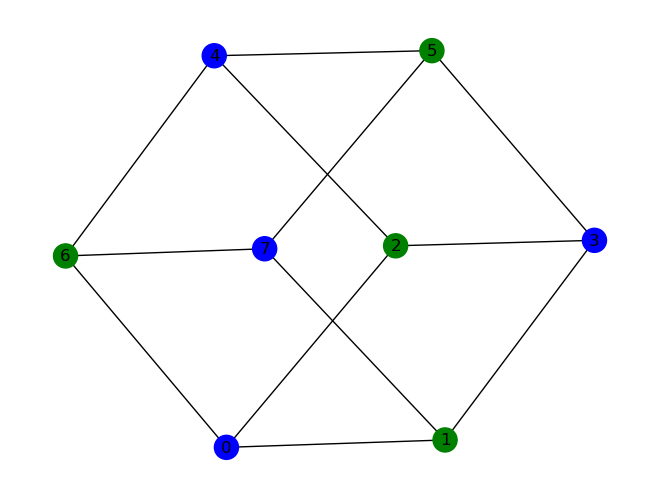

In [262]:
G = build_test_graph1()
calculate_DNN_result(G, calculate_large_G(G), True)

In [263]:
networks = build_n_graphs(20, lambda: nx.erdos_renyi_graph(100,0.1), )

In [266]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 27
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 26
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 27
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 27
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 27
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 28
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 26
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 28
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 30
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 26
INFO:root:Processing graph 10...
INFO:root:Total MIS length found = 28
INFO:root:Processing graph 11...
INFO:root:Total MIS length found = 29
INFO:root:Processing graph 12...
INFO:root:Total MIS length found = 29
INFO:root:Processing graph 13...
INFO:root:Total MIS length found = 29
INFO:root:Proces

Average edges count = 496.0
Average dNN result = 27.45


In [267]:
networks = build_n_graphs(10, lambda: nx.erdos_renyi_graph(100,0.2), )

In [268]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 18
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 17
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 17
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 17
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 14
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 17
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 16
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 16
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 18
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 18


Average edges count = 982.8
Average dNN result = 16.8


In [269]:
networks = build_n_graphs(10, lambda: nx.erdos_renyi_graph(200,0.1))

In [270]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 35
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 33
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 38
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 32
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 32
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 35
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 38
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 34
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 33
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 32


Average edges count = 1985.7
Average dNN result = 34.2


In [271]:
networks = build_n_graphs(10, lambda: nx.erdos_renyi_graph(200,0.2))

In [272]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 17
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 20
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 18
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 20
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 18
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 18
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 22
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 21
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 19
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 21


Average edges count = 4002.4
Average dNN result = 19.4


In [273]:
def build_stochastic_params(s,p,q = 0.05):
    sizes = []
    probs = []
    for i in range(5):
        sizes.append(s)
        prob = []
        for j in range(5):
            if i != j:
                prob.append(q)
            else:
                prob.append(p)
        probs.append(prob)
    return (sizes, probs)

In [274]:
(sizes, probs) = build_stochastic_params(50,0.1)

In [275]:
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))

In [276]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 50
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 55
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 51
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 52
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 50
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 51
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 51
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 53
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 54
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 56


Average edges count = 1858.7
Average dNN result = 52.3


In [277]:
(sizes, probs) = build_stochastic_params(50,0.2)
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 42
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 46
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 46
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 44
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 44
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 41
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 43
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 43
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 42


Average edges count = 2452.8
Average dNN result = 43.6


In [278]:
(sizes, probs) = build_stochastic_params(70,0.1)
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 57
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 57
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 57
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 58
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 57
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 58
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 55


Average edges count = 3705.5
Average dNN result = 57.9


In [279]:
(sizes, probs) = build_stochastic_params(70,0.2)
networks = build_n_graphs(10, lambda: nx.stochastic_block_model(sizes,probs))
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 47
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 46
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 44
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 48
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 47
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 50
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 46
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 50


Average edges count = 4842.1
Average dNN result = 46.8


In [280]:
networks=build_n_graphs(10, lambda: nx.barabasi_albert_graph(100,45))
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 45
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 45


Average edges count = 2475.0
Average dNN result = 45.0


In [281]:
networks = build_n_graphs(10, lambda: nx.barabasi_albert_graph(200,100))
networks += build_n_graphs(10, lambda: nx.barabasi_albert_graph(200,90))

In [282]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 100
INFO:root:Processing graph 10...
INFO:root:Total MIS length found = 90
INFO:root:Processing graph 11...
INFO:root:Total MIS length found = 90
INFO:root:Processing graph 12...
INFO:root:Total MIS length found = 90
INFO:root:Processing graph 13...
INFO:root:Total MIS length found = 90
INFO:r

Average edges count = 9950.0
Average dNN result = 95.0


In [283]:
networks = build_n_graphs(10, lambda: nx.powerlaw_cluster_graph(100,30,0.5))

In [288]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 30
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 30
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 30
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 30
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 30
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 30
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 30
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 30
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 30
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 30


Average edges count = 2012.4
Average dNN result = 30.0


In [289]:
networks = build_n_graphs(10, lambda: nx.powerlaw_cluster_graph(200,60,0.5))

In [290]:
test_network_on_graphs(networks)

INFO:root:Processing graph 0...
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 1...
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 2...
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 3...
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 4...
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 5...
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 6...
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 7...
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 8...
INFO:root:Total MIS length found = 60
INFO:root:Processing graph 9...
INFO:root:Total MIS length found = 60


Average edges count = 8093.4
Average dNN result = 60.0


In [ ]:
# wiki_vote_G = read_G_from_file('datasets/Wiki-Vote.txt')
# G = wiki_vote_G
# correct_G = nx.Graph()
# nodes = dict()
# index = 0
# for node in G.nodes():
#     nodes[node] =index
#     index+=1
#     correct_G.add_node(index)
# for (u,v) in G.edges():
#     u_c = nodes[u]
#     v_c = nodes[v]
#     correct_G.add_edge(u_c,v_c)
#     correct_G.add_edge(v_c,u_c)
# print(correct_G)

In [ ]:
# print(calculate_large_G(correct_G))